In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from bart_playground import *
import bartz
from stochtree import BARTModel
import time

## Wine Quality Data

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
winequality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = winequality.data.features 
y = winequality.data.targets 

# variable information 
print(winequality.variables)

                    name     role         type demographic  \
0          fixed_acidity  Feature   Continuous        None   
1       volatile_acidity  Feature   Continuous        None   
2            citric_acid  Feature   Continuous        None   
3         residual_sugar  Feature   Continuous        None   
4              chlorides  Feature   Continuous        None   
5    free_sulfur_dioxide  Feature   Continuous        None   
6   total_sulfur_dioxide  Feature   Continuous        None   
7                density  Feature   Continuous        None   
8                     pH  Feature   Continuous        None   
9              sulphates  Feature   Continuous        None   
10               alcohol  Feature   Continuous        None   
11               quality   Target      Integer        None   
12                 color    Other  Categorical        None   

               description units missing_values  
0                     None  None             no  
1                     None  Non

In [3]:
X

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8


In [3]:
y

,quality
0,5
1,5
2,5
3,6
4,5
...,...
6492,6
6493,5
6494,6
6495,7


In [4]:
print(X.describe())

       fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000         

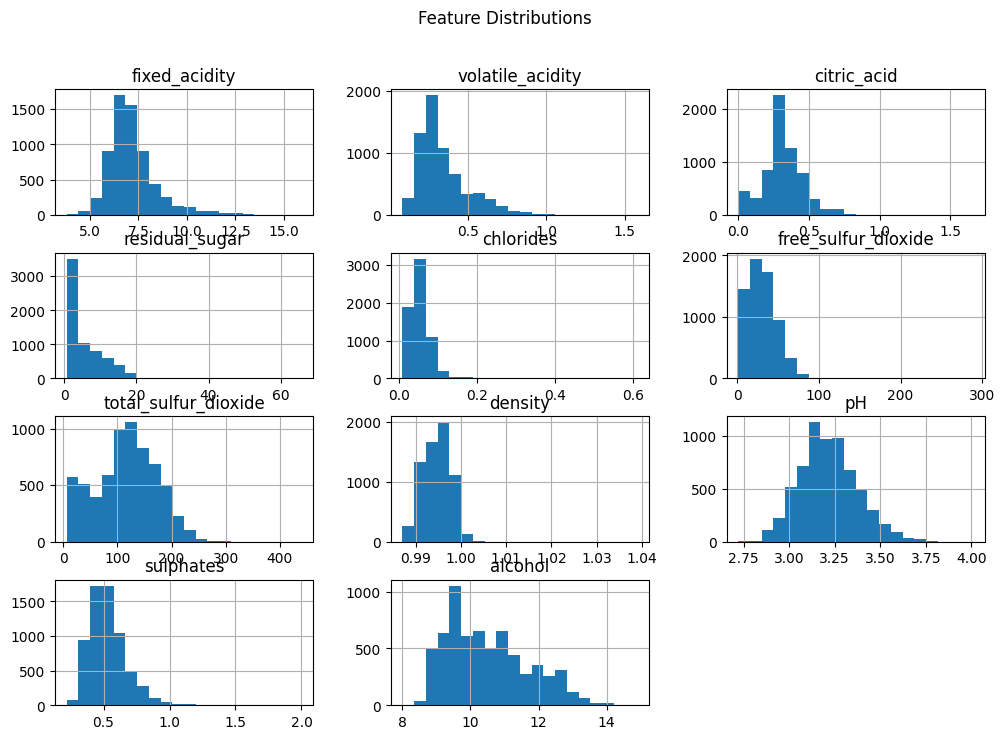

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

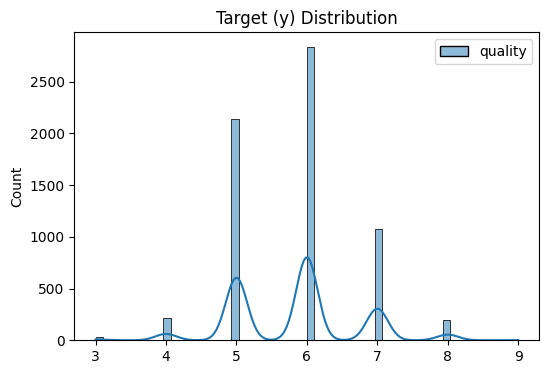

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

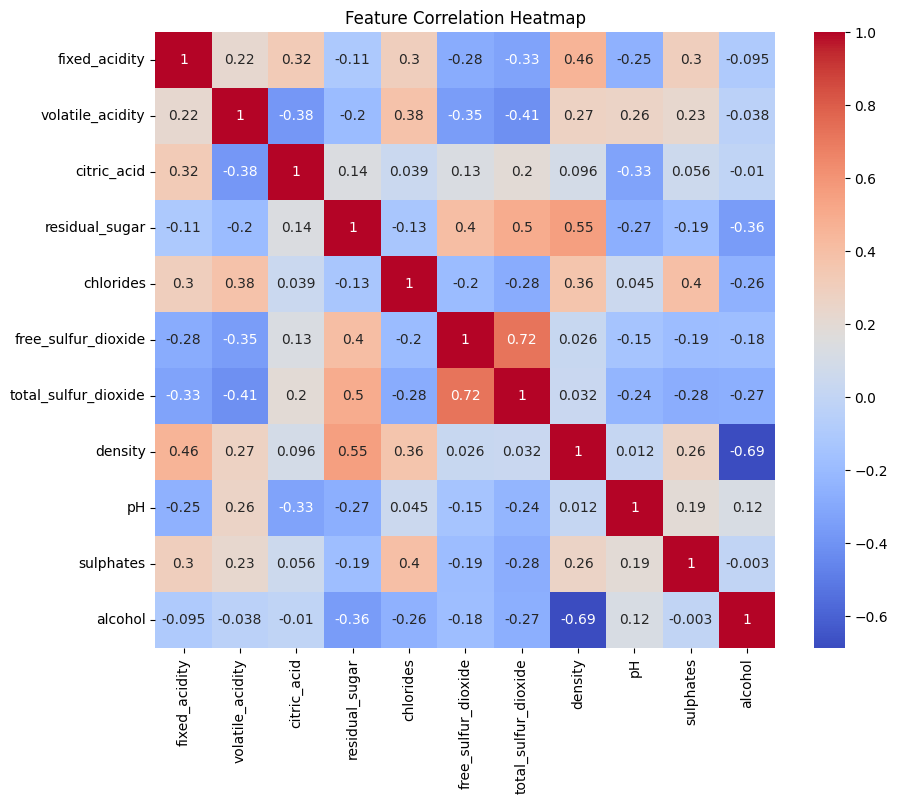

In [7]:
plt.figure(figsize=(10, 8))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [4]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [5]:
test_mse_results = {name: [] for name in ["bart", "btz", "sto", "rf", "xgb", "lr"]}
train_mse_results = {name: [] for name in ["bart", "btz", "sto", "rf", "xgb", "lr"]}
pi_length_results = {name: [] for name in ["bart", "btz", "sto"]}
time_results = {name: [] for name in ["bart", "btz", "sto", "rf", "xgb", "lr"]}

In [6]:
n_runs = 10
n_skip = 100
n_post = 200
n_trees = 100
for seed in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
    
    # bart
    t0 = time.time()
    bart = DefaultBART(ndpost=n_post, nskip=n_skip, n_trees=n_trees)
    bart.fit(X_train, y_train)
    time_results["bart"].append(time.time() - t0)
    
    # btz
    t0 = time.time()
    btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=n_trees, ndpost=n_post, nskip=n_skip)
    btpred_all_test = btz.predict(np.transpose(X_test))
    btpred_test = np.mean(np.array(btpred_all_test), axis=0)
    btpred_all_train = btz.predict(np.transpose(X_train))
    btpred_train = np.mean(np.array(btpred_all_train), axis=0)
    time_results["btz"].append(time.time() - t0)
    
    # sto
    t0 = time.time()
    sto = BARTModel()
    sto.sample(X_train=X_train, y_train=y_train,
               num_gfr=0, num_burnin=n_skip, num_mcmc=n_post, 
               mean_forest_params={"num_trees": n_trees})
    sto_pred_all_test = sto.predict(X_test)
    sto_pred_test = np.mean(sto_pred_all_test, axis=1)
    sto_pred_train = np.mean(sto.predict(X_train), axis=1)
    time_results["sto"].append(time.time() - t0)

    # rf
    t0 = time.time()
    rf = RandomForestRegressor(n_estimators=n_trees, random_state=seed)
    rf.fit(X_train, y_train)
    time_results["rf"].append(time.time() - t0)

    # xgb
    t0 = time.time()
    xgbr = xgb.XGBRegressor(n_estimators=n_trees, random_state=seed, verbosity=0)
    xgbr.fit(X_train, y_train)
    time_results["xgb"].append(time.time() - t0)

    # lr
    t0 = time.time()
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    time_results["lr"].append(time.time() - t0)
    
    # Test MSE
    test_mse_results["bart"].append(mean_squared_error(y_test, bart.predict(X_test)))
    test_mse_results["btz"].append(mean_squared_error(y_test, btpred_test))
    test_mse_results["sto"].append(mean_squared_error(y_test, sto_pred_test))
    test_mse_results["rf"].append(mean_squared_error(y_test, rf.predict(X_test)))
    test_mse_results["xgb"].append(mean_squared_error(y_test, xgbr.predict(X_test)))
    test_mse_results["lr"].append(mean_squared_error(y_test, lr.predict(X_test)))

    # Train MSE
    train_mse_results["bart"].append(mean_squared_error(y_train, bart.predict(X_train)))
    train_mse_results["btz"].append(mean_squared_error(y_train, btpred_train))
    train_mse_results["sto"].append(mean_squared_error(y_train, sto_pred_train))
    train_mse_results["rf"].append(mean_squared_error(y_train, rf.predict(X_train)))
    train_mse_results["xgb"].append(mean_squared_error(y_train, xgbr.predict(X_train)))
    train_mse_results["lr"].append(mean_squared_error(y_train, lr.predict(X_train)))

    # Prediction intervals
    # btz: axis=0, shape (n_mcmc, n_test)
    btz_lower = np.percentile(btpred_all_test, 2.5, axis=0)
    btz_upper = np.percentile(btpred_all_test, 97.5, axis=0)
    pi_length_results["btz"].append(np.mean(btz_upper - btz_lower))
    
    # sto: axis=1, shape (n_test, n_mcmc)
    sto_lower = np.percentile(sto_pred_all_test, 2.5, axis=1)
    sto_upper = np.percentile(sto_pred_all_test, 97.5, axis=1)
    pi_length_results["sto"].append(np.mean(sto_upper - sto_lower))
    
    # bart: axis=1, shape (n_test, n_mcmc)
    bart_pred_all_test = bart.posterior_f(X_test)
    bart_lower = np.percentile(bart_pred_all_test, 2.5, axis=1)
    bart_upper = np.percentile(bart_pred_all_test, 97.5, axis=1)
    pi_length_results["bart"].append(np.mean(bart_upper - bart_lower))


Iterations:   0%|          | 0/300 [00:00<?, ?it/s]

Iterations: 100%|██████████| 300/300 [01:39<00:00,  3.01it/s]
INFO:2025-05-27 12:20:32,070:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


Iteration 100/300 P_grow=0.55 P_prune=0.45 A_grow=0.22 A_prune=0.24 (burnin)
Iteration 200/300 P_grow=0.56 P_prune=0.44 A_grow=0.29 A_prune=0.11
Iteration 300/300 P_grow=0.52 P_prune=0.48 A_grow=0.27 A_prune=0.21


Iterations: 100%|██████████| 300/300 [01:34<00:00,  3.17it/s]


Iteration 100/300 P_grow=0.57 P_prune=0.43 A_grow=0.12 A_prune=0.26 (burnin)
Iteration 200/300 P_grow=0.54 P_prune=0.46 A_grow=0.11 A_prune=0.17
Iteration 300/300 P_grow=0.53 P_prune=0.47 A_grow=0.15 A_prune=0.21


Iterations: 100%|██████████| 300/300 [01:33<00:00,  3.22it/s]


Iteration 100/300 P_grow=0.56 P_prune=0.44 A_grow=0.25 A_prune=0.30 (burnin)
Iteration 200/300 P_grow=0.54 P_prune=0.46 A_grow=0.17 A_prune=0.20
Iteration 300/300 P_grow=0.55 P_prune=0.45 A_grow=0.16 A_prune=0.16


Iterations: 100%|██████████| 300/300 [01:29<00:00,  3.36it/s]


Iteration 100/300 P_grow=0.57 P_prune=0.43 A_grow=0.21 A_prune=0.30 (burnin)
Iteration 200/300 P_grow=0.55 P_prune=0.45 A_grow=0.16 A_prune=0.16
Iteration 300/300 P_grow=0.55 P_prune=0.45 A_grow=0.13 A_prune=0.31


Iterations: 100%|██████████| 300/300 [01:29<00:00,  3.37it/s]


Iteration 100/300 P_grow=0.54 P_prune=0.46 A_grow=0.19 A_prune=0.24 (burnin)
Iteration 200/300 P_grow=0.57 P_prune=0.43 A_grow=0.21 A_prune=0.14
Iteration 300/300 P_grow=0.50 P_prune=0.50 A_grow=0.12 A_prune=0.32


Iterations: 100%|██████████| 300/300 [01:29<00:00,  3.34it/s]


Iteration 100/300 P_grow=0.57 P_prune=0.43 A_grow=0.12 A_prune=0.30 (burnin)
Iteration 200/300 P_grow=0.54 P_prune=0.46 A_grow=0.22 A_prune=0.17
Iteration 300/300 P_grow=0.55 P_prune=0.45 A_grow=0.20 A_prune=0.24


Iterations: 100%|██████████| 300/300 [01:32<00:00,  3.24it/s]


Iteration 100/300 P_grow=0.56 P_prune=0.44 A_grow=0.16 A_prune=0.23 (burnin)
Iteration 200/300 P_grow=0.52 P_prune=0.48 A_grow=0.13 A_prune=0.06
Iteration 300/300 P_grow=0.51 P_prune=0.49 A_grow=0.12 A_prune=0.22


Iterations: 100%|██████████| 300/300 [01:28<00:00,  3.40it/s]


Iteration 100/300 P_grow=0.58 P_prune=0.42 A_grow=0.17 A_prune=0.26 (burnin)
Iteration 200/300 P_grow=0.52 P_prune=0.48 A_grow=0.12 A_prune=0.12
Iteration 300/300 P_grow=0.53 P_prune=0.47 A_grow=0.17 A_prune=0.23


Iterations: 100%|██████████| 300/300 [01:32<00:00,  3.25it/s]


Iteration 100/300 P_grow=0.57 P_prune=0.43 A_grow=0.12 A_prune=0.28 (burnin)
Iteration 200/300 P_grow=0.57 P_prune=0.43 A_grow=0.16 A_prune=0.09
Iteration 300/300 P_grow=0.53 P_prune=0.47 A_grow=0.19 A_prune=0.23


Iterations: 100%|██████████| 300/300 [01:28<00:00,  3.41it/s]


Iteration 100/300 P_grow=0.57 P_prune=0.43 A_grow=0.19 A_prune=0.16 (burnin)
Iteration 200/300 P_grow=0.54 P_prune=0.46 A_grow=0.28 A_prune=0.17
Iteration 300/300 P_grow=0.52 P_prune=0.48 A_grow=0.15 A_prune=0.23


In [7]:
import pandas as pd

test_mse_df = pd.DataFrame(test_mse_results)
train_mse_df = pd.DataFrame(train_mse_results)
pi_length_df = pd.DataFrame(pi_length_results)
time_df = pd.DataFrame(time_results)

print(f"Test MSE ({n_runs} runs):")
print(f"Train MSE ({n_runs} runs):")
print("Test MSE Mean:")
print(test_mse_df.mean())
print("Train MSE Mean:")
print(train_mse_df.mean())

print(f"Prediction Interval Mean Length ({n_runs} runs):")
print(f"Prediction Interval Mean Length (Mean over {n_runs} runs):")
print(pi_length_df.mean())

print(f"Average Training Time (seconds) over {n_runs} runs:")
print(time_df.mean())

Test MSE (10 runs):
Train MSE (10 runs):
Test MSE Mean:
bart    0.469641
btz     0.481304
sto     0.477452
rf      0.372950
xgb     0.408515
lr      0.543759
dtype: float64
Train MSE Mean:
bart    0.401948
btz     0.429083
sto     0.428995
rf      0.052093
xgb     0.063829
lr      0.538872
dtype: float64
Prediction Interval Mean Length (10 runs):
Prediction Interval Mean Length (Mean over 10 runs):
bart    0.580788
btz     0.518506
sto     0.507197
dtype: float64
Average Training Time (seconds) over 10 runs:
bart    91.722903
btz      6.823093
sto      6.363481
rf       2.495870
xgb      0.173848
lr       0.003109
dtype: float64


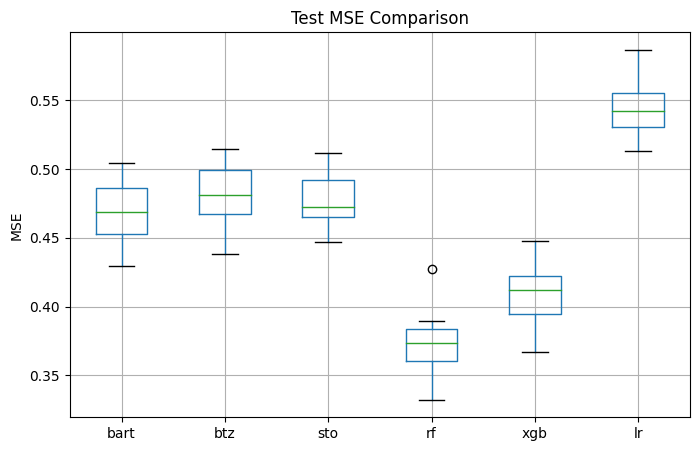

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
test_mse_df.boxplot()
plt.title("Test MSE Comparison")
plt.ylabel("MSE")
plt.grid(True, axis='y')
plt.show()

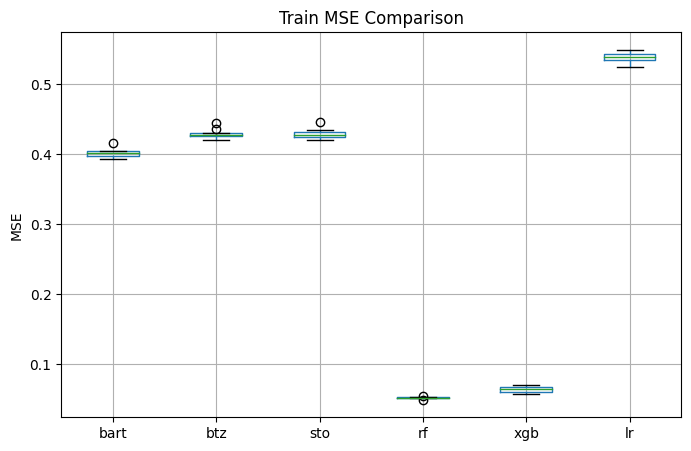

In [9]:
plt.figure(figsize=(8, 5))
train_mse_df.boxplot()
plt.title("Train MSE Comparison")
plt.ylabel("MSE")
plt.grid(True, axis='y')
plt.show()

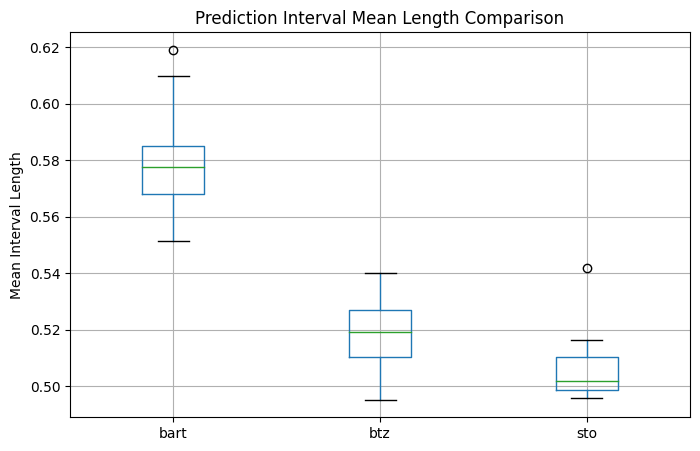

In [10]:
plt.figure(figsize=(8, 5))
pi_length_df.boxplot()
plt.title("Prediction Interval Mean Length Comparison")
plt.ylabel("Mean Interval Length")
plt.grid(True, axis='y')
plt.show()

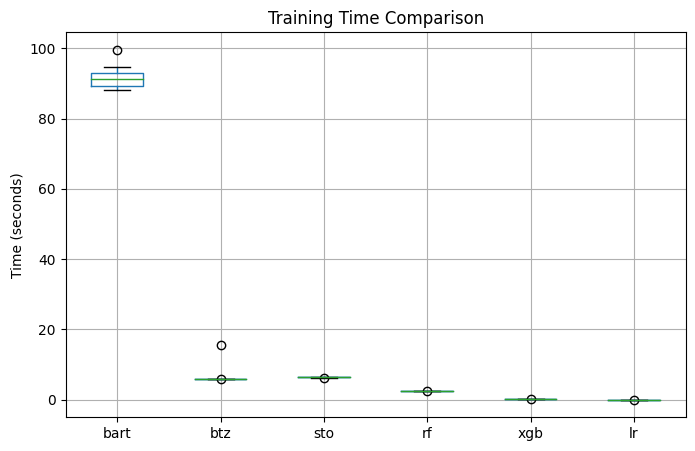

In [11]:
plt.figure(figsize=(8, 5))
time_df.boxplot()
plt.title("Training Time Comparison")
plt.ylabel("Time (seconds)")
plt.grid(True, axis='y')
plt.show()